In [1]:
from datetime import datetime
from finance_utils.backtest import Backtest
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [11]:
universe = pd.read_csv('/Users/henrywzh/Documents/data/us_big.csv')
universe.set_index('Date', inplace=True)
universe.index = pd.to_datetime(universe.index)
mag7 = ['GOOGL', 'AMZN', 'AAPL', 'META', 'MSFT', 'NVDA', 'TSLA']
top15_sp500 = mag7 + ['GOOG', 'BRK-B', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V']

In [12]:
u_2010 = universe[universe.index >= '2010-01-01']
u_2010[top15_sp500]

,GOOGL,AMZN,AAPL,META,MSFT,NVDA,TSLA,GOOG,BRK-B,UNH,XOM,LLY,JPM,JNJ,V
Date,,,,,,,,,,,,,,,
2010-01-04,15.666453,6.695000,6.461976,NaN,23.389402,0.423988,NaN,15.592496,66.220001,25.389574,39.913593,23.735548,29.335224,42.308628,19.822802
2010-01-05,15.597464,6.734500,6.473149,NaN,23.396948,0.430179,NaN,15.523831,66.540001,25.349304,40.069443,23.318083,29.903467,41.818035,19.595659
2010-01-06,15.204272,6.612500,6.370184,NaN,23.253380,0.432931,NaN,15.132495,66.199997,25.598938,40.415764,23.490366,30.067768,42.158192,19.332529
2010-01-07,14.850323,6.500000,6.358407,NaN,23.011543,0.424447,NaN,14.780218,66.459999,26.581341,40.288776,23.371094,30.663368,41.857273,19.512447
2010-01-08,15.048295,6.676000,6.400681,NaN,23.170237,0.425364,NaN,14.977255,66.440002,26.331713,40.127148,23.192188,30.588055,42.001179,19.566410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06,158.289993,161.929993,207.229996,494.089996,399.609985,104.250000,200.639999,160.539993,422.140015,568.349976,114.160004,793.179993,200.339996,158.970001,257.743164
2024-08-07,158.940002,162.770004,209.820007,488.920013,398.429993,98.910004,191.759995,160.750000,427.019989,566.080017,115.680000,772.140015,200.399994,158.899994,256.006622
2024-08-08,162.029999,165.800003,213.309998,509.630005,402.690002,104.970001,198.839996,163.839996,431.540009,566.239990,117.889999,845.309998,204.059998,160.220001,259.309998


In [21]:
eps_metadata = pd.read_csv('/Users/henrywzh/Documents/database/sp500_top15_%_eps.csv')
eps_dates = eps_metadata.pivot_table(index='reportedDate', columns='symbol', values='reportedEPS')
eps_dates.index = pd.to_datetime(eps_dates.index)
eps_dates = eps_dates[eps_dates.index >= '2010-01-01']

symbol,AAPL,AMZN,BRK-B,GOOG,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
reportedDate,,,,,,,,,,,,,,,
2010-01-15,NaN,NaN,NaN,NaN,NaN,NaN,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-21,NaN,NaN,NaN,NaN,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.81,NaN,NaN
2010-01-25,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-26,NaN,NaN,NaN,NaN,NaN,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-28,NaN,0.04,NaN,NaN,NaN,NaN,NaN,0.91,NaN,0.74,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.16,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01,1.40,1.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.14


In [73]:
df_list = []
for ticker in top15_sp500:
    temp_eps = eps_dates[ticker].dropna().rolling(4).sum().dropna()
    temp_eps.name = 'eps'
    
    temp_df = pd.merge(u_2010[ticker], temp_eps, left_index=True, right_index=True, how='outer')

    # Drop first n na, fill the rest
    temp_df = temp_df[temp_df['eps'].notnull().argmax():].ffill()
    temp_df['eps'] = np.where(temp_df['eps'] <= 0, 0.01, temp_df['eps'])
    temp_df[f'{ticker} PE'] = temp_df[ticker] / temp_df['eps']
    df_list.append(temp_df[f'{ticker} PE'])

In [74]:
top15_pe = pd.concat(df_list, axis=1)
pe_2015 = top15_pe.dropna()
pe_2015

,GOOGL PE,AMZN PE,AAPL PE,META PE,MSFT PE,NVDA PE,TSLA PE,GOOG PE,BRK-B PE,UNH PE,XOM PE,LLY PE,JPM PE,JNJ PE,V PE
2015-01-29,20.040722,1558.899975,14.306290,44.994244,14.369462,18.262173,228.000005,1.954744,22.031625,16.605435,7.241775,21.504283,8.083834,13.216930,25.515053
2015-01-30,20.990375,1772.649956,14.096932,43.788632,13.818768,17.726678,226.222213,2.046077,21.673193,16.128784,7.228543,21.394519,7.896512,12.927757,26.225976
2015-02-02,20.781467,1822.349930,14.273805,43.257926,14.119766,18.114446,234.377782,2.022957,22.097891,16.286656,8.000929,21.302407,8.054795,13.016831,26.270217
2015-02-03,20.824420,1817.749977,14.276210,43.494437,14.229220,18.566842,242.622217,2.025866,22.332830,16.365588,8.239402,21.064693,8.236304,13.227260,26.728046
2015-02-04,20.543272,1823.749924,14.385702,43.627109,14.311317,18.613009,242.833328,2.001061,22.218373,16.382287,8.168843,20.865605,8.186932,13.085256,27.252750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06,22.710186,38.739233,31.541856,25.221541,33.836578,57.916667,85.743589,23.032998,21.692704,21.302473,12.755308,108.953296,12.466708,15.168893,26.653895
2024-08-07,22.803444,38.940192,31.936074,24.957632,33.736663,54.950002,81.948716,23.063128,21.943473,21.217392,12.925140,106.063189,12.470441,15.162213,26.474315
2024-08-08,23.246772,39.665073,32.467275,26.014804,34.097375,58.316667,84.974357,23.506456,22.175746,21.223388,13.172067,92.993399,12.698195,15.288168,26.815925
2024-08-09,23.482066,39.937800,32.913243,26.430323,34.379339,58.194444,85.470085,23.728838,22.182426,20.943029,13.279329,98.094609,12.806472,15.326335,26.862462


In [89]:
pe_2015_pct = pe_2015.pct_change().fillna(0)
pe_2015_pct.resample('ME').mean()

,GOOGL PE,AMZN PE,AAPL PE,META PE,MSFT PE,NVDA PE,TSLA PE,GOOG PE,BRK-B PE,UNH PE,XOM PE,LLY PE,JPM PE,JNJ PE,V PE
2015-01-31,0.023693,0.068558,-0.007317,-0.013397,-0.019162,-0.014661,-0.003899,0.023362,-0.008134,-0.014352,-0.000914,-0.002552,-0.011586,-0.010939,0.013931
2015-02-28,0.002464,0.003753,0.005144,0.002164,0.004728,0.002301,0.051985,0.002358,0.001300,0.003611,0.005474,-0.000936,0.006365,0.001648,0.003442
2015-03-31,-0.000567,-0.000908,-0.001357,0.001926,-0.003353,-0.002184,-0.003147,-0.000780,-0.001459,0.002091,-0.001797,0.001699,-0.000455,-0.000792,-0.001569
2015-04-30,-0.000989,0.006495,-0.003667,-0.004092,0.010226,0.002865,0.008869,0.039865,-0.001022,-0.005674,0.008196,-0.003216,0.000913,-0.000800,-0.001057
2015-05-31,-0.000261,0.000926,0.002312,0.000335,-0.001461,0.000346,0.104187,-0.000435,-0.001418,0.003853,-0.000813,0.005086,0.001987,0.000864,0.002122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.001132,-0.009491,-0.000201,-0.011601,-0.005309,-0.001399,0.009961,-0.001032,-0.002620,-0.002430,0.004729,-0.005998,-0.002453,-0.004162,-0.003754
2024-05-31,0.002689,0.000439,0.005620,0.003818,0.003069,-0.001284,-0.000997,0.002556,-0.001697,0.001174,0.000048,0.002450,0.002609,0.001112,0.000760
2024-06-30,0.002989,0.004913,0.005025,0.004229,0.003928,0.006844,0.005822,0.002910,-0.000959,0.001784,-0.000893,0.005236,-0.000032,-0.000161,-0.001913
2024-07-31,-0.005501,-0.001378,0.002526,-0.007546,-0.003889,-0.001512,0.015968,-0.005401,0.003459,0.004617,0.001423,-0.005132,0.004023,0.003505,-0.000566


<Axes: >

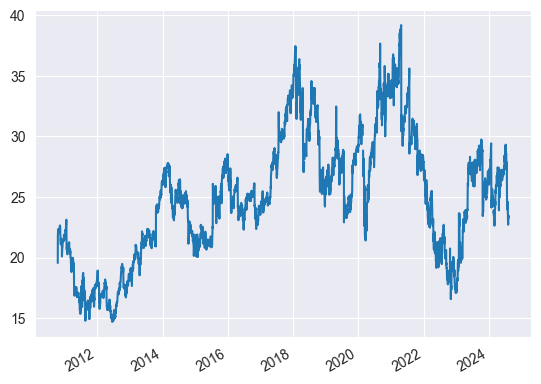

In [75]:
top15_pe['GOOGL PE'].plot()

ratio = fast / slow - 1
- ratio > 0: recent prices are above the historic average

In [157]:
# -- Ranking --
fast = 42
slow = 250
holding_period = 21

datas = []

for i in range(10):
    returns = []
    vals = []
    stocks = []
    
    for col in u_2010.columns:
        ts_factor, ts_future_rets = test_factor(u_2010[col], fast, slow, holding_period)
        if ts_factor is None:
            continue
        
        returns.append(ts_future_rets.iloc[-(1 + i * 5)])
        vals.append(ts_factor.iloc[-(1 + i * 5)])
        stocks.append(col)
        
    data = pd.DataFrame({'Future Return': returns, 'Factor Value': vals}, index=stocks)
    datas.append(data)

In [158]:
def ranking(_data):
    # Rank the equities
    ranked_data = _data.sort_values(by=['Factor Value'])
    
    # Compute the returns of each basket
    # Baskets of size 500, so we create an empty array of shape (10000/500)
    number_of_baskets = 20
    basket_returns = np.zeros(number_of_baskets)
    
    for i in range(number_of_baskets):
        start = i * 20
        end = i * 20 + 20 
        basket_returns[i] = ranked_data[start:end]['Future Return'].mean()
    
    # Plot the returns of each basket
    plt.bar(range(number_of_baskets), basket_returns)
    plt.ylabel('Returns')
    plt.xlabel('Basket')
    plt.legend(['Returns of Each Basket'])

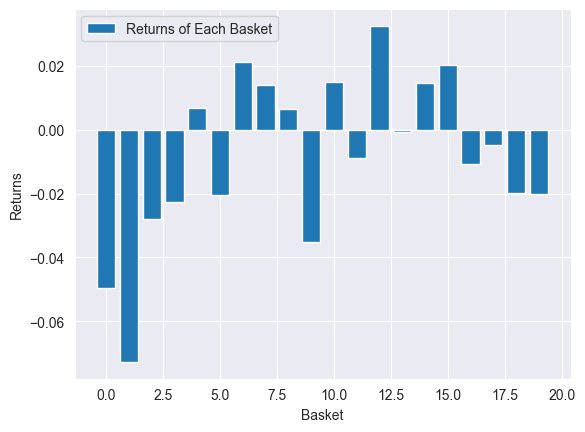

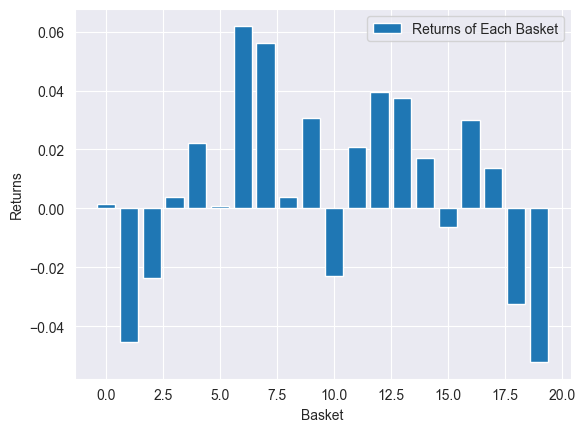

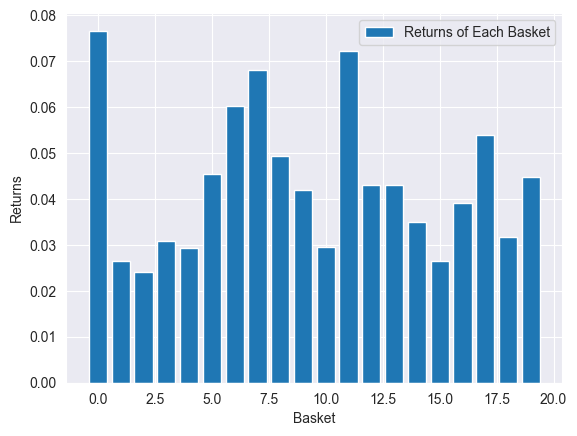

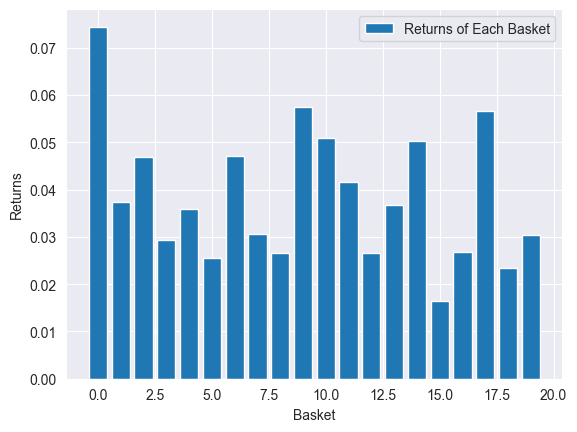

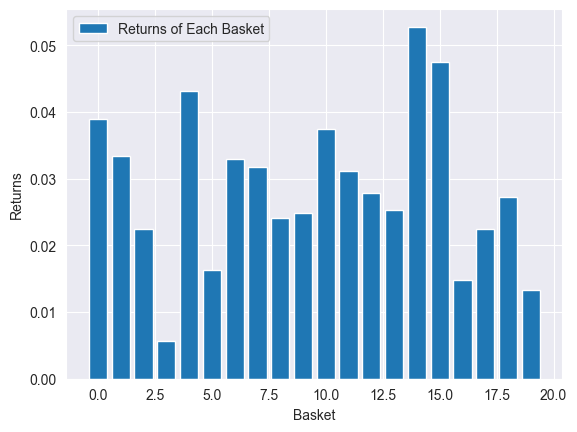

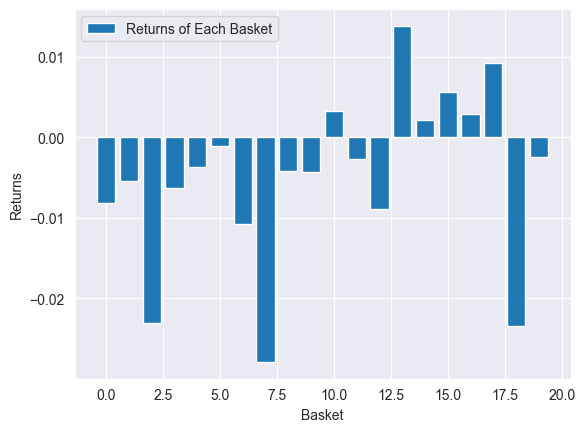

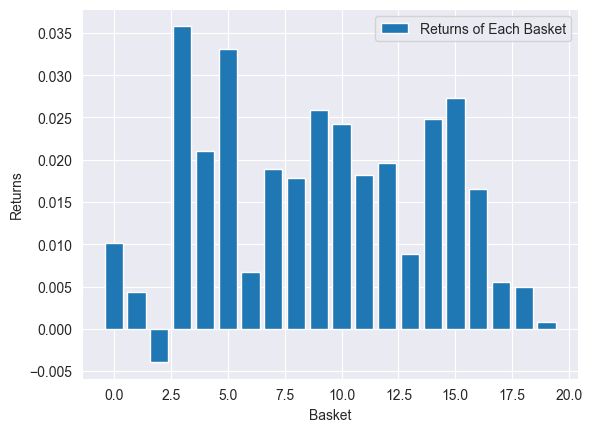

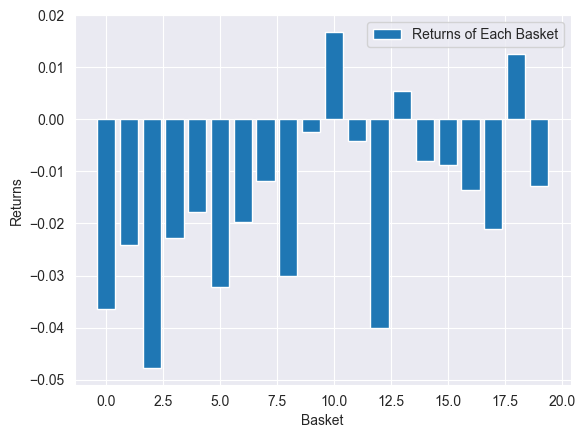

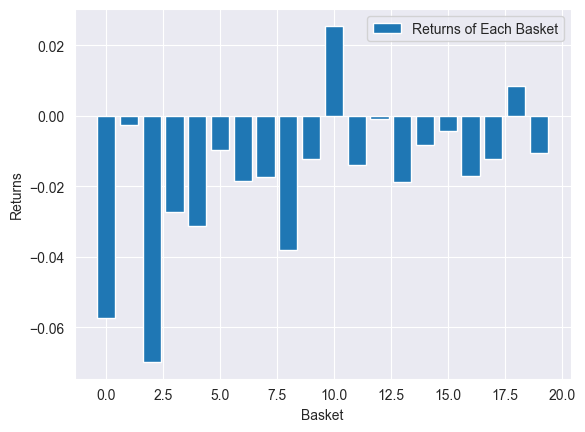

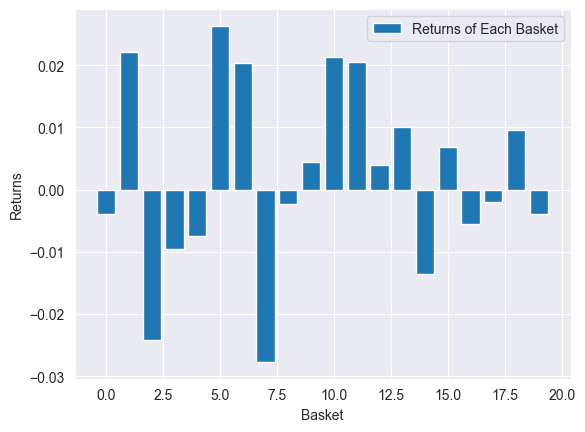

In [161]:
for d in datas:
    ranking(d)
    plt.show()